In [2]:
import pandas as pd
import numpy as np
import csv
import re
import string
from collections import defaultdict
#from google.colab import drive
#drive.mount('/content/drive')


In [2]:
url_test = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTj6g3GFhmQ6N_K--THLISk2TzpfGkI6vTK2_jaENX6INU2BFPr1pIc6Fs5DryL2Q/pub?gid=1844931619&single=true&output=tsv'
url_train = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQ2v-WuHn21qUQSz5RsEKmDCkxnKu9Zgcc-sVnV--hx_83vRfILre3Tc-btU4VUUg/pub?gid=207380422&single=true&output=tsv'


# Load and inspect the data

Load all data and then drop all columns with no label

In [3]:
from io import StringIO
import requests
r_train = requests.get(url_train)
data_train = r_train.content.decode('utf8')
df_train_dev = pd.read_csv(StringIO(data_train), sep = '\t')
df_train_dev.columns= ['bug', 'label']
df_train_dev.dropna(subset=['label'], inplace=True)

r_test = requests.get(url_test)
data_test= r_test.content.decode('utf8')
df_test = pd.read_csv(StringIO(data_test), sep = '\t')
df_test.columns= ['bug', 'label']
df_test.dropna(subset=['label'], inplace=True)


In [4]:
print('Infos train-dev-set:')
print(df_train_dev.info())
print('Infos test-set:')
print(df_test.info())


Infos train-dev-set:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11916 entries, 0 to 11915
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   bug     11916 non-null  object
 1   label   11916 non-null  object
dtypes: object(2)
memory usage: 279.3+ KB
None
Infos test-set:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1199 entries, 0 to 1198
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   bug     1199 non-null   object
 1   label   1199 non-null   object
dtypes: object(2)
memory usage: 28.1+ KB
None


In [7]:
print(df_train_dev.label.unique())


['blocker' 'critical' 'major' 'normal' 'minor' 'trivial']


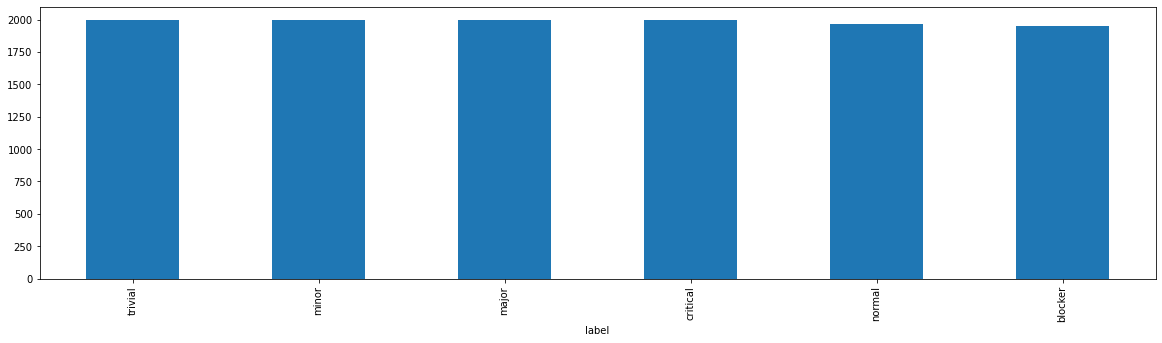

In [8]:
df_train_dev.groupby('label').size().sort_values(ascending = False).plot.bar(figsize=(20, 5))


In [9]:
df_train_dev.groupby('label').size().sort_values(ascending = False)


label
trivial     2000
minor       2000
major       2000
critical    2000
normal      1965
blocker     1951
dtype: int64

In [5]:
# remove all non necessary parts of the bug summary
def remove_noise(string):
    # remove special cgars
    string = (" ".join(re.findall(r"[A-Za-z0-9üäöÜÄÖß.!()]*", string))).replace("  "," ")
   
    return string



In [6]:

df_train_dev['bug'] =  df_train_dev['bug'].apply(lambda t: remove_noise(str(t)))
df_test['bug'] =  df_test['bug'].apply(lambda t: remove_noise(str(t)))

In [7]:
df_test.head()

,bug,label
0,The browser wa properties view media nodes.js ...,blocker
1,Browser Toolbox can t be resized,blocker
2,WebConsole helper function always returns null,blocker
3,Web console is buggy in window mode,blocker
4,browser perf button states.js and browser mark...,blocker


# Process labels

In [8]:
from sklearn.preprocessing import LabelEncoder
le_fitted = LabelEncoder().fit(df_train_dev['label'])


In [9]:
# map all classes that are not in train_dev to undefined
for i, label in enumerate(df_test['label']):
    df_test['label'][i] = 'und' if label not in le_fitted.classes_ else label

# check if it worked: should return an empty list
print([label for label in df_test['label'] if label not in set(df_train_dev['label'])])


[]


In [57]:
df_train_dev['label'][:10]


0    blocker
1    blocker
2    blocker
3    blocker
4    blocker
5    blocker
6    blocker
7    blocker
8    blocker
9    blocker
Name: label, dtype: object

In [10]:
y_train_dev, y_test = le_fitted.transform(df_train_dev['label']), le_fitted.transform(df_test['label'])


In [11]:
x_train = df_train_dev.bug
y_train = y_train_dev
x_test = df_test.bug
y_test = y_test


Creating a pipeline for the processing of words into ngramm with range (1,1), (1,2) and (1,3). And transforming into Tfidd representation

In [12]:
# Creating a pipeline
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

text_clf = Pipeline([
                      ('ngram_count_vect', CountVectorizer(ngram_range=(1, 3), analyzer='word')), # Convert a collection of text documents to a matrix of unigram, bigram and trigram counts
                      ('tfidf_ngram_transformer', TfidfTransformer(smooth_idf=True)) # Convert to tf-idf measure
])

# Pipelining training data
x_train_prepared = text_clf.fit_transform(x_train)

# Pipelining our test and dev data
x_test_prepared = text_clf.transform(x_test)


In [13]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# Train a Naïve Bayes classifier
nb_clf = MultinomialNB()
nb_clf.fit(x_train_prepared, y_train)

accuracy_score(nb_clf.predict(x_test_prepared), y_test)


0.4662218515429525

In [14]:
from sklearn.linear_model import SGDClassifier

# Train a SGD classifier
sgd_clf = SGDClassifier()
sgd_clf.fit(x_train_prepared, y_train)
accuracy_score(sgd_clf.predict(x_test_prepared), y_test)


0.4553794829024187

In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

# Scores of NB classifier
print('Scores of Naïve Bayes classifier:')
y_train_predictions_nb = cross_val_predict(nb_clf, x_train_prepared, y_train, cv=3)
print(f'precision: {precision_score(y_train, y_train_predictions_nb, average="micro")}')
print(f'recall: {recall_score(y_train, y_train_predictions_nb, average="micro")}')
print(f'f1: {f1_score(y_train, y_train_predictions_nb, average="micro")} \n')

# Scores of SGD classifier
print('Scores of SGD classifier:')
y_train_predictions_sgd = cross_val_predict(sgd_clf, x_train_prepared, y_train, cv=3)
print(f'precision: {precision_score(y_train, y_train_predictions_sgd, average="micro")}')
print(f'recall: {recall_score(y_train, y_train_predictions_sgd, average="micro")}')
print(f'f1: {f1_score(y_train, y_train_predictions_sgd, average="micro")} \n')



Scores of Naïve Bayes classifier:
precision: 0.40231621349446123
recall: 0.40231621349446123
f1: 0.40231621349446123 

Scores of SGD classifier:
precision: 0.40483383685800606
recall: 0.40483383685800606
f1: 0.4048338368580061 



<function matplotlib.pyplot.show>

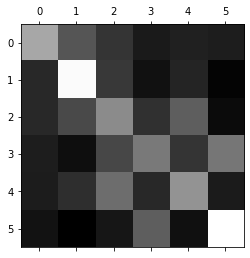

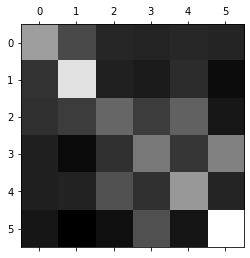

In [16]:
import matplotlib.pyplot as plt

# Confusion matrices
conf_mx_nb = confusion_matrix(y_train, y_train_predictions_nb)
conf_mx_sgd = confusion_matrix(y_train, y_train_predictions_sgd)


# NB classifier
plt.matshow(conf_mx_nb, cmap=plt.cm.gray)
plt.show

# SGD classifier
plt.matshow(conf_mx_sgd, cmap=plt.cm.gray)
plt.show



# Grid Searches to Find Optimal Parameters for Naive bayes and SGD Classifiers
Including a confusion Matrix and best scores for each best model

1. Naive Bayes

In [17]:
from sklearn.model_selection import GridSearchCV

# Grid Search for Naïve Bayes Classifier
text_clf_nb = Pipeline([
                      ('ngram_count_vect', CountVectorizer(ngram_range=(1, 3), analyzer='word')), # Convert a collection of text documents to a matrix of unigram, bigram and trigram counts
                      ('tfidf_ngram_transformer', TfidfTransformer(smooth_idf=True)), # Convert to tf-idf measure
                      ('nb_clf', MultinomialNB())
])

text_clf_nb.fit(x_train, y_train)

# Make a parameter grid for NB
param_grid_nb = {'ngram_count_vect__ngram_range': [(1,1), (1, 2), (1, 3)],
              'ngram_count_vect__analyzer': ['word']
              }

gs_nb = GridSearchCV(text_clf_nb, param_grid_nb, cv=5, n_jobs=4, verbose=1, scoring='accuracy')
gs_nb.fit(x_train, y_train)

nb_df = pd.DataFrame.from_dict(gs_nb.cv_results_)
nb_df.sort_values(by=["rank_test_score"])

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:    9.6s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ngram_count_vect__analyzer,param_ngram_count_vect__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,2.026758,0.618002,0.148421,0.051784,word,"(1, 3)","{'ngram_count_vect__analyzer': 'word', 'ngram_...",0.344799,0.417961,0.429710,0.464121,0.447335,0.420785,0.041096,1
1,1.417816,0.074669,0.163992,0.012093,word,"(1, 2)","{'ngram_count_vect__analyzer': 'word', 'ngram_...",0.343121,0.417541,0.423836,0.462442,0.448175,0.419023,0.041283,2
0,0.555484,0.037601,0.093727,0.009850,word,"(1, 1)","{'ngram_count_vect__analyzer': 'word', 'ngram_...",0.330956,0.413345,0.412505,0.459085,0.438103,0.410799,0.043500,3


In [18]:
# best model of NB with test data
best_model = Pipeline([
    ('ngram_count_vect', CountVectorizer(ngram_range=(1,3), analyzer='word')),
    ('tfidf_ngram_transformer', TfidfTransformer()),
    ('nb_clf', MultinomialNB())
])

best_model.fit(x_train, y_train)
accuracy_score(best_model.predict(x_test), y_test)

0.4662218515429525

In [19]:
print('Scores of best Naïve Bayes classifier:')
y_train_predictions_nb = cross_val_predict(best_model,x_train, y_train, cv=3)
print(f'precision: {precision_score(y_train, y_train_predictions_nb, average="micro")}')
print(f'recall: {recall_score(y_train, y_train_predictions_nb, average="micro")}')
print(f'f1: {f1_score(y_train, y_train_predictions_nb, average="micro")} \n')

Scores of best Naïve Bayes classifier:
precision: 0.40181268882175225
recall: 0.40181268882175225
f1: 0.40181268882175225 



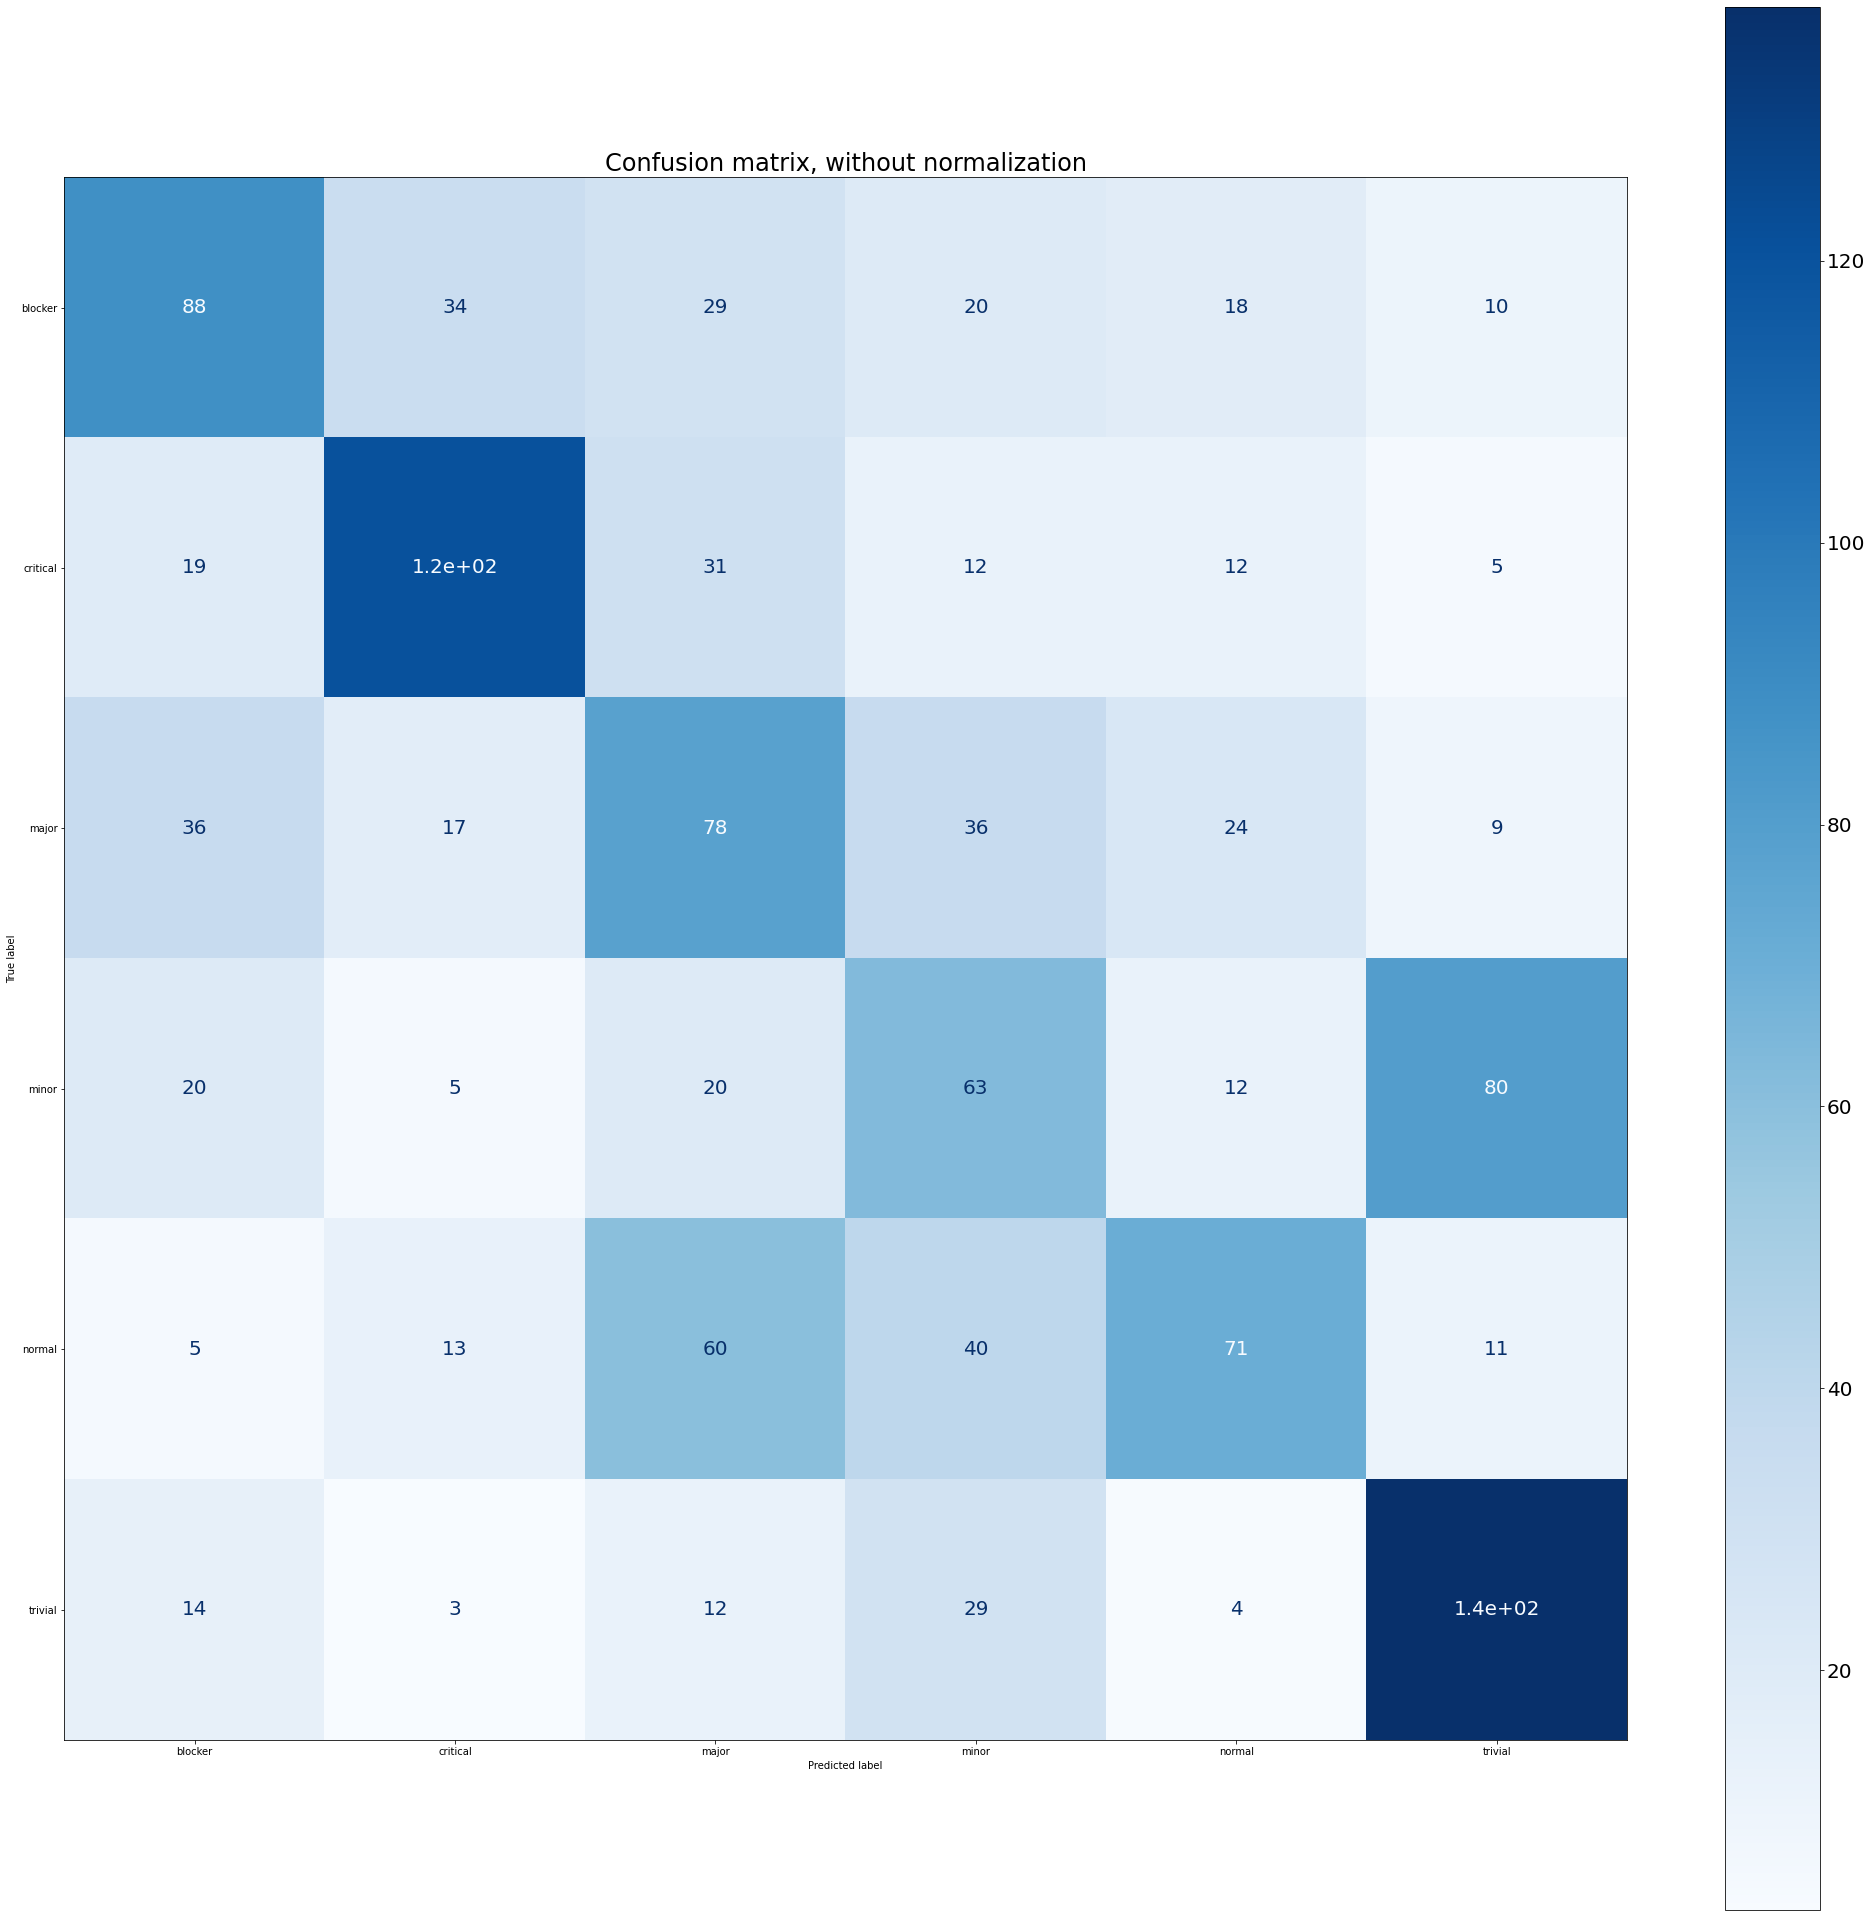

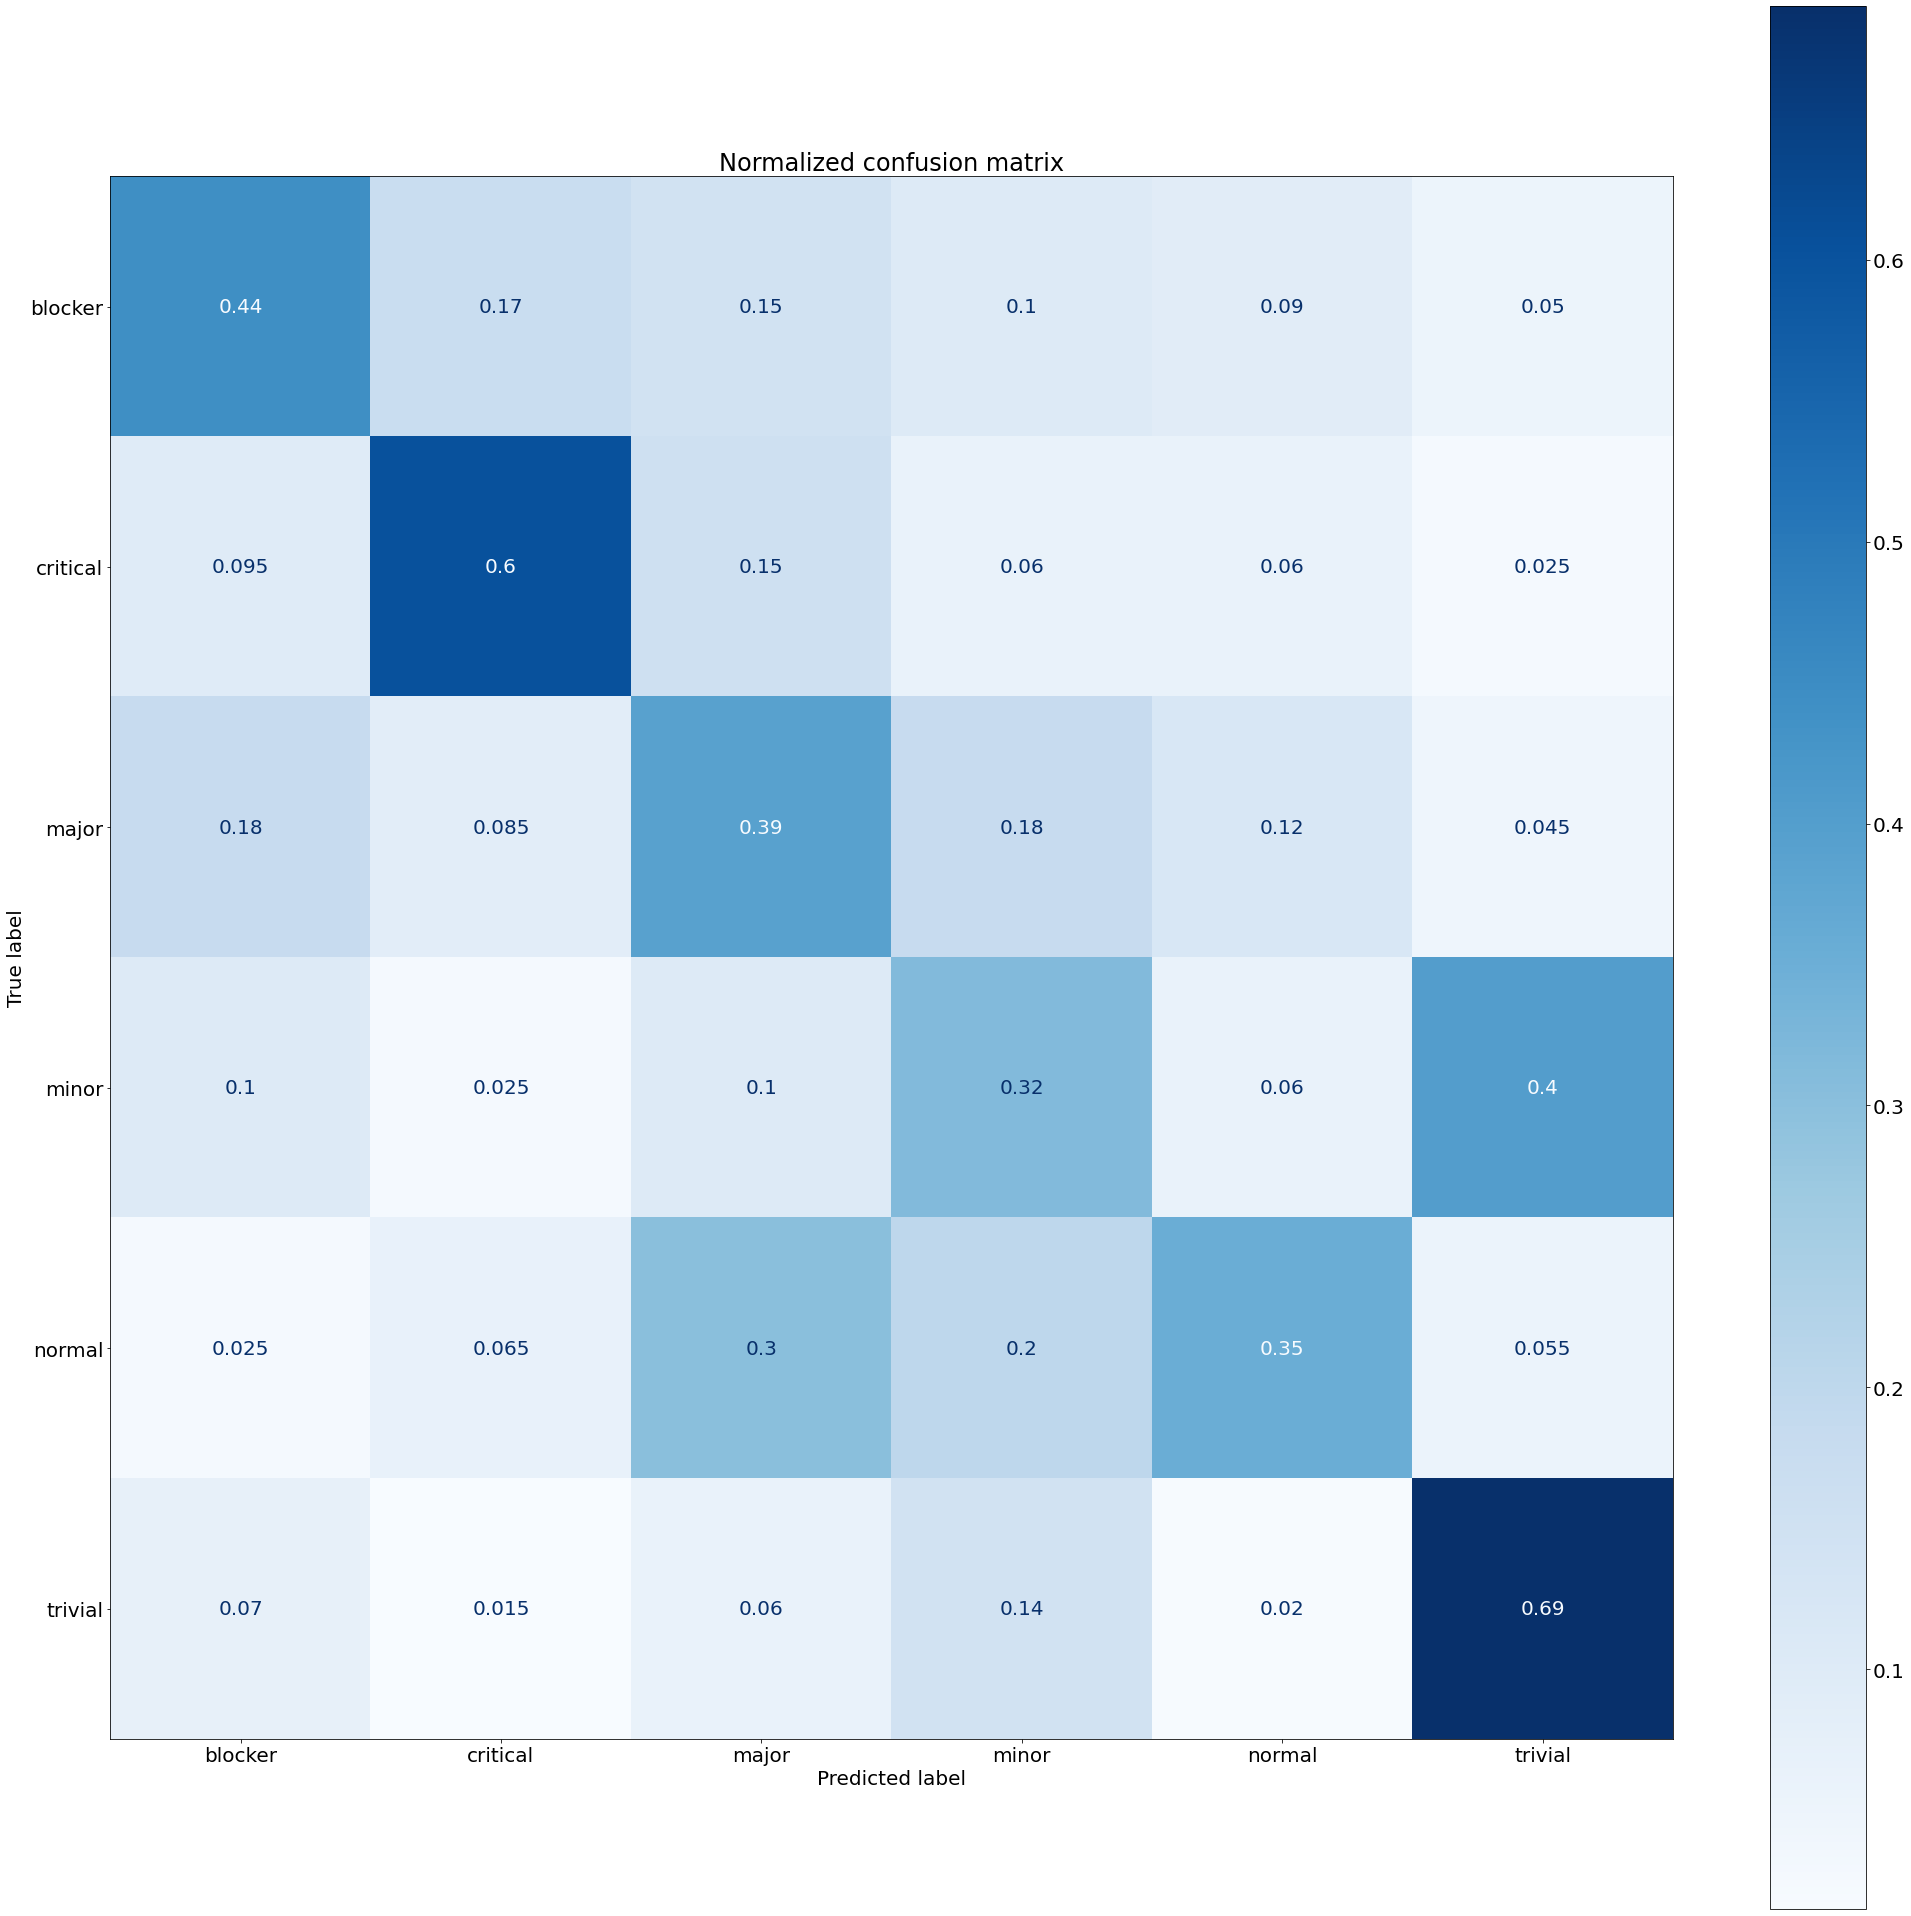

In [20]:
from sklearn.metrics import plot_confusion_matrix
# Plot non-normalized and normalized confusion matrix for naive bayes
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
dis_label =['blocker', 'critical', 'major', 'minor', 'normal','trivial']
for title, normalize in titles_options:
    fig, ax = plt.subplots(figsize=(35,35))
    plt.rcParams.update({'font.size': 20})
    disp = plot_confusion_matrix(best_model, x_test, y_test,
                                 display_labels=dis_label,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize,
                                 ax=ax)
    disp.ax_.set_title(title)


 

plt.show()

2. SGD Classifier

In [ ]:
from sklearn.model_selection import GridSearchCV

# Grid Search for SGD Classifier
text_clf_sgd = Pipeline([
                      ('ngram_count_vect', CountVectorizer(ngram_range=(1, 3), analyzer='word')), # Convert a collection of text documents to a matrix of unigram, bigram and trigram counts
                      ('tfidf_ngram_transformer', TfidfTransformer(smooth_idf=True)), # Convert to tf-idf measure
                      ('sgd_clf', SGDClassifier())
])

text_clf_sgd.fit(x_train, y_train)

# Make a parameter grid for SGD classifier
param_grid_sgd = {'sgd_clf__loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
                  'sgd_clf__penalty': ['l1', 'l2', 'elasticnet'],
                  'sgd_clf__early_stopping': [True, False],
                  'ngram_count_vect__ngram_range': [(1,1), (1, 2), (1, 3)],
                  'ngram_count_vect__analyzer': ['word']}

gs_sgd = GridSearchCV(text_clf_sgd, param_grid_sgd, cv=5, n_jobs=4, verbose=1, scoring='accuracy')
gs_sgd.fit(x_train, y_train)

sgd_df = pd.DataFrame.from_dict(gs_sgd.cv_results_)
sgd_df.sort_values(by=["rank_test_score"])

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  2.7min


In [31]:
# Best SGD Model
best_model = Pipeline([
    ('ngram_count_vect', CountVectorizer(ngram_range=(1,2), analyzer='word')),
    ('tfidf_ngram_transformer', TfidfTransformer(smooth_idf=True)),
    ('sgd_clf', SGDClassifier(loss='log', penalty='l2',early_stopping = False ))
])

best_model.fit(x_train, y_train)
accuracy_score(best_model.predict(x_test), y_test)

0.47289407839866554

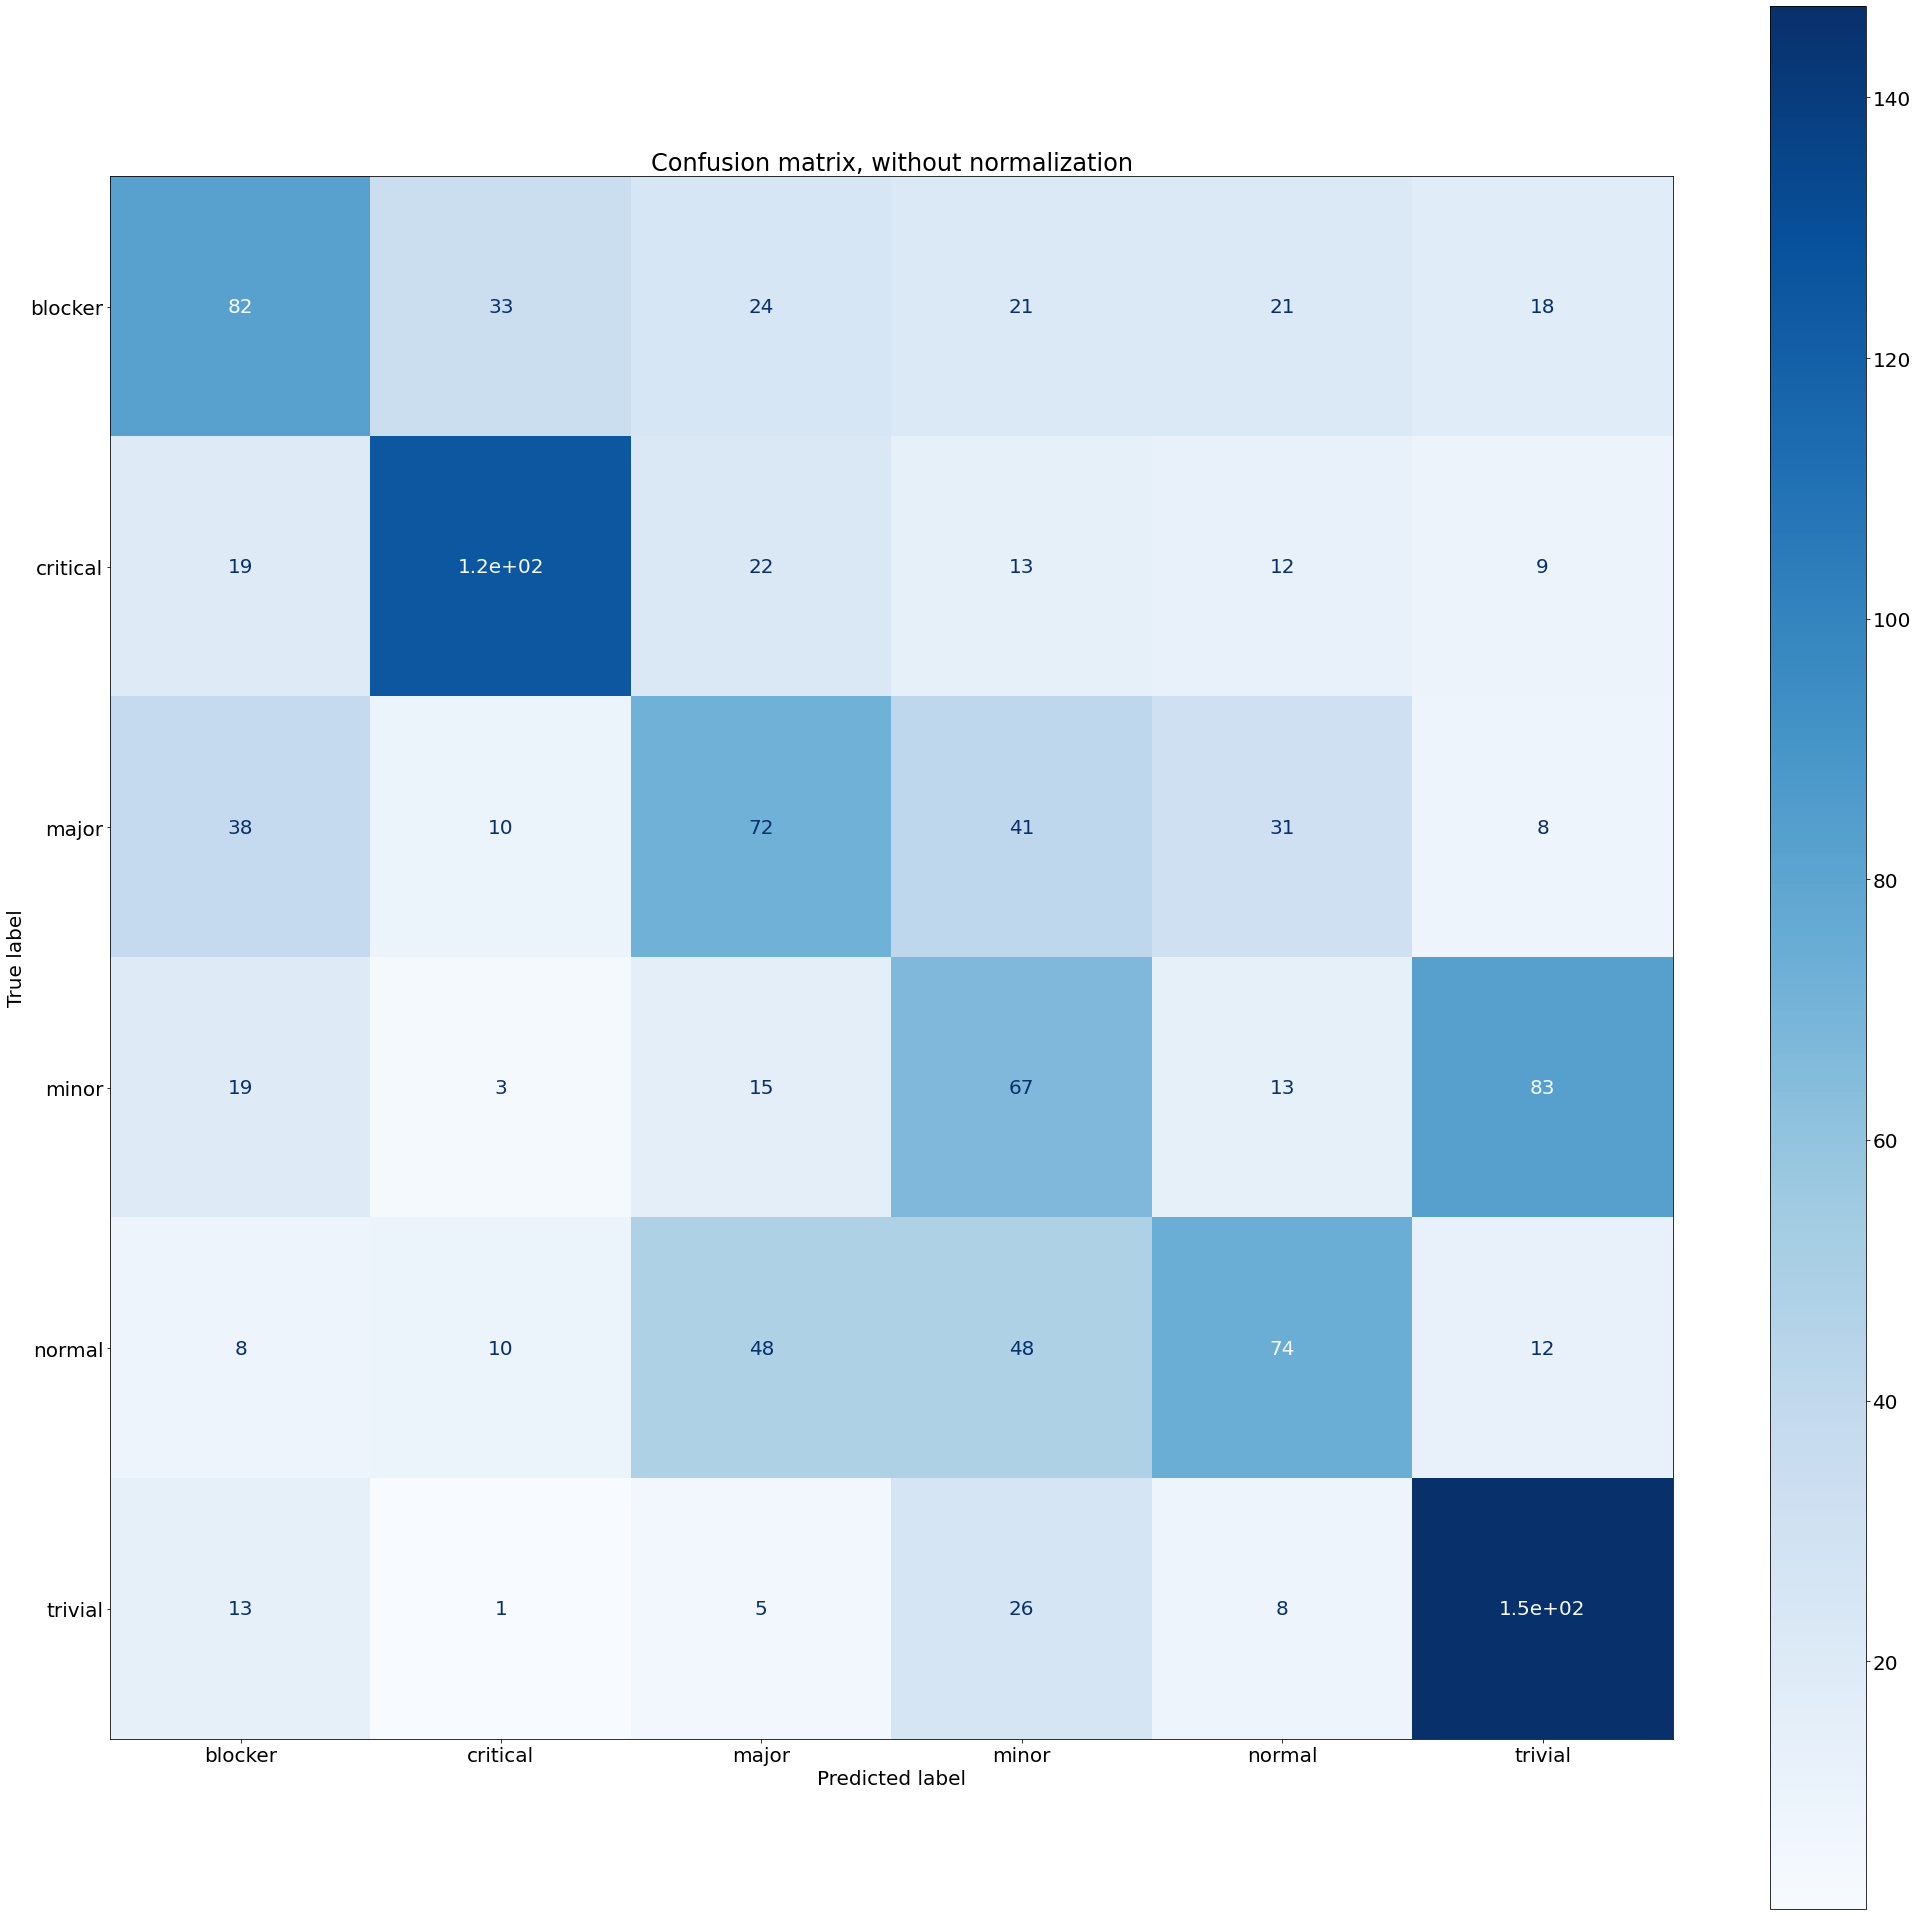

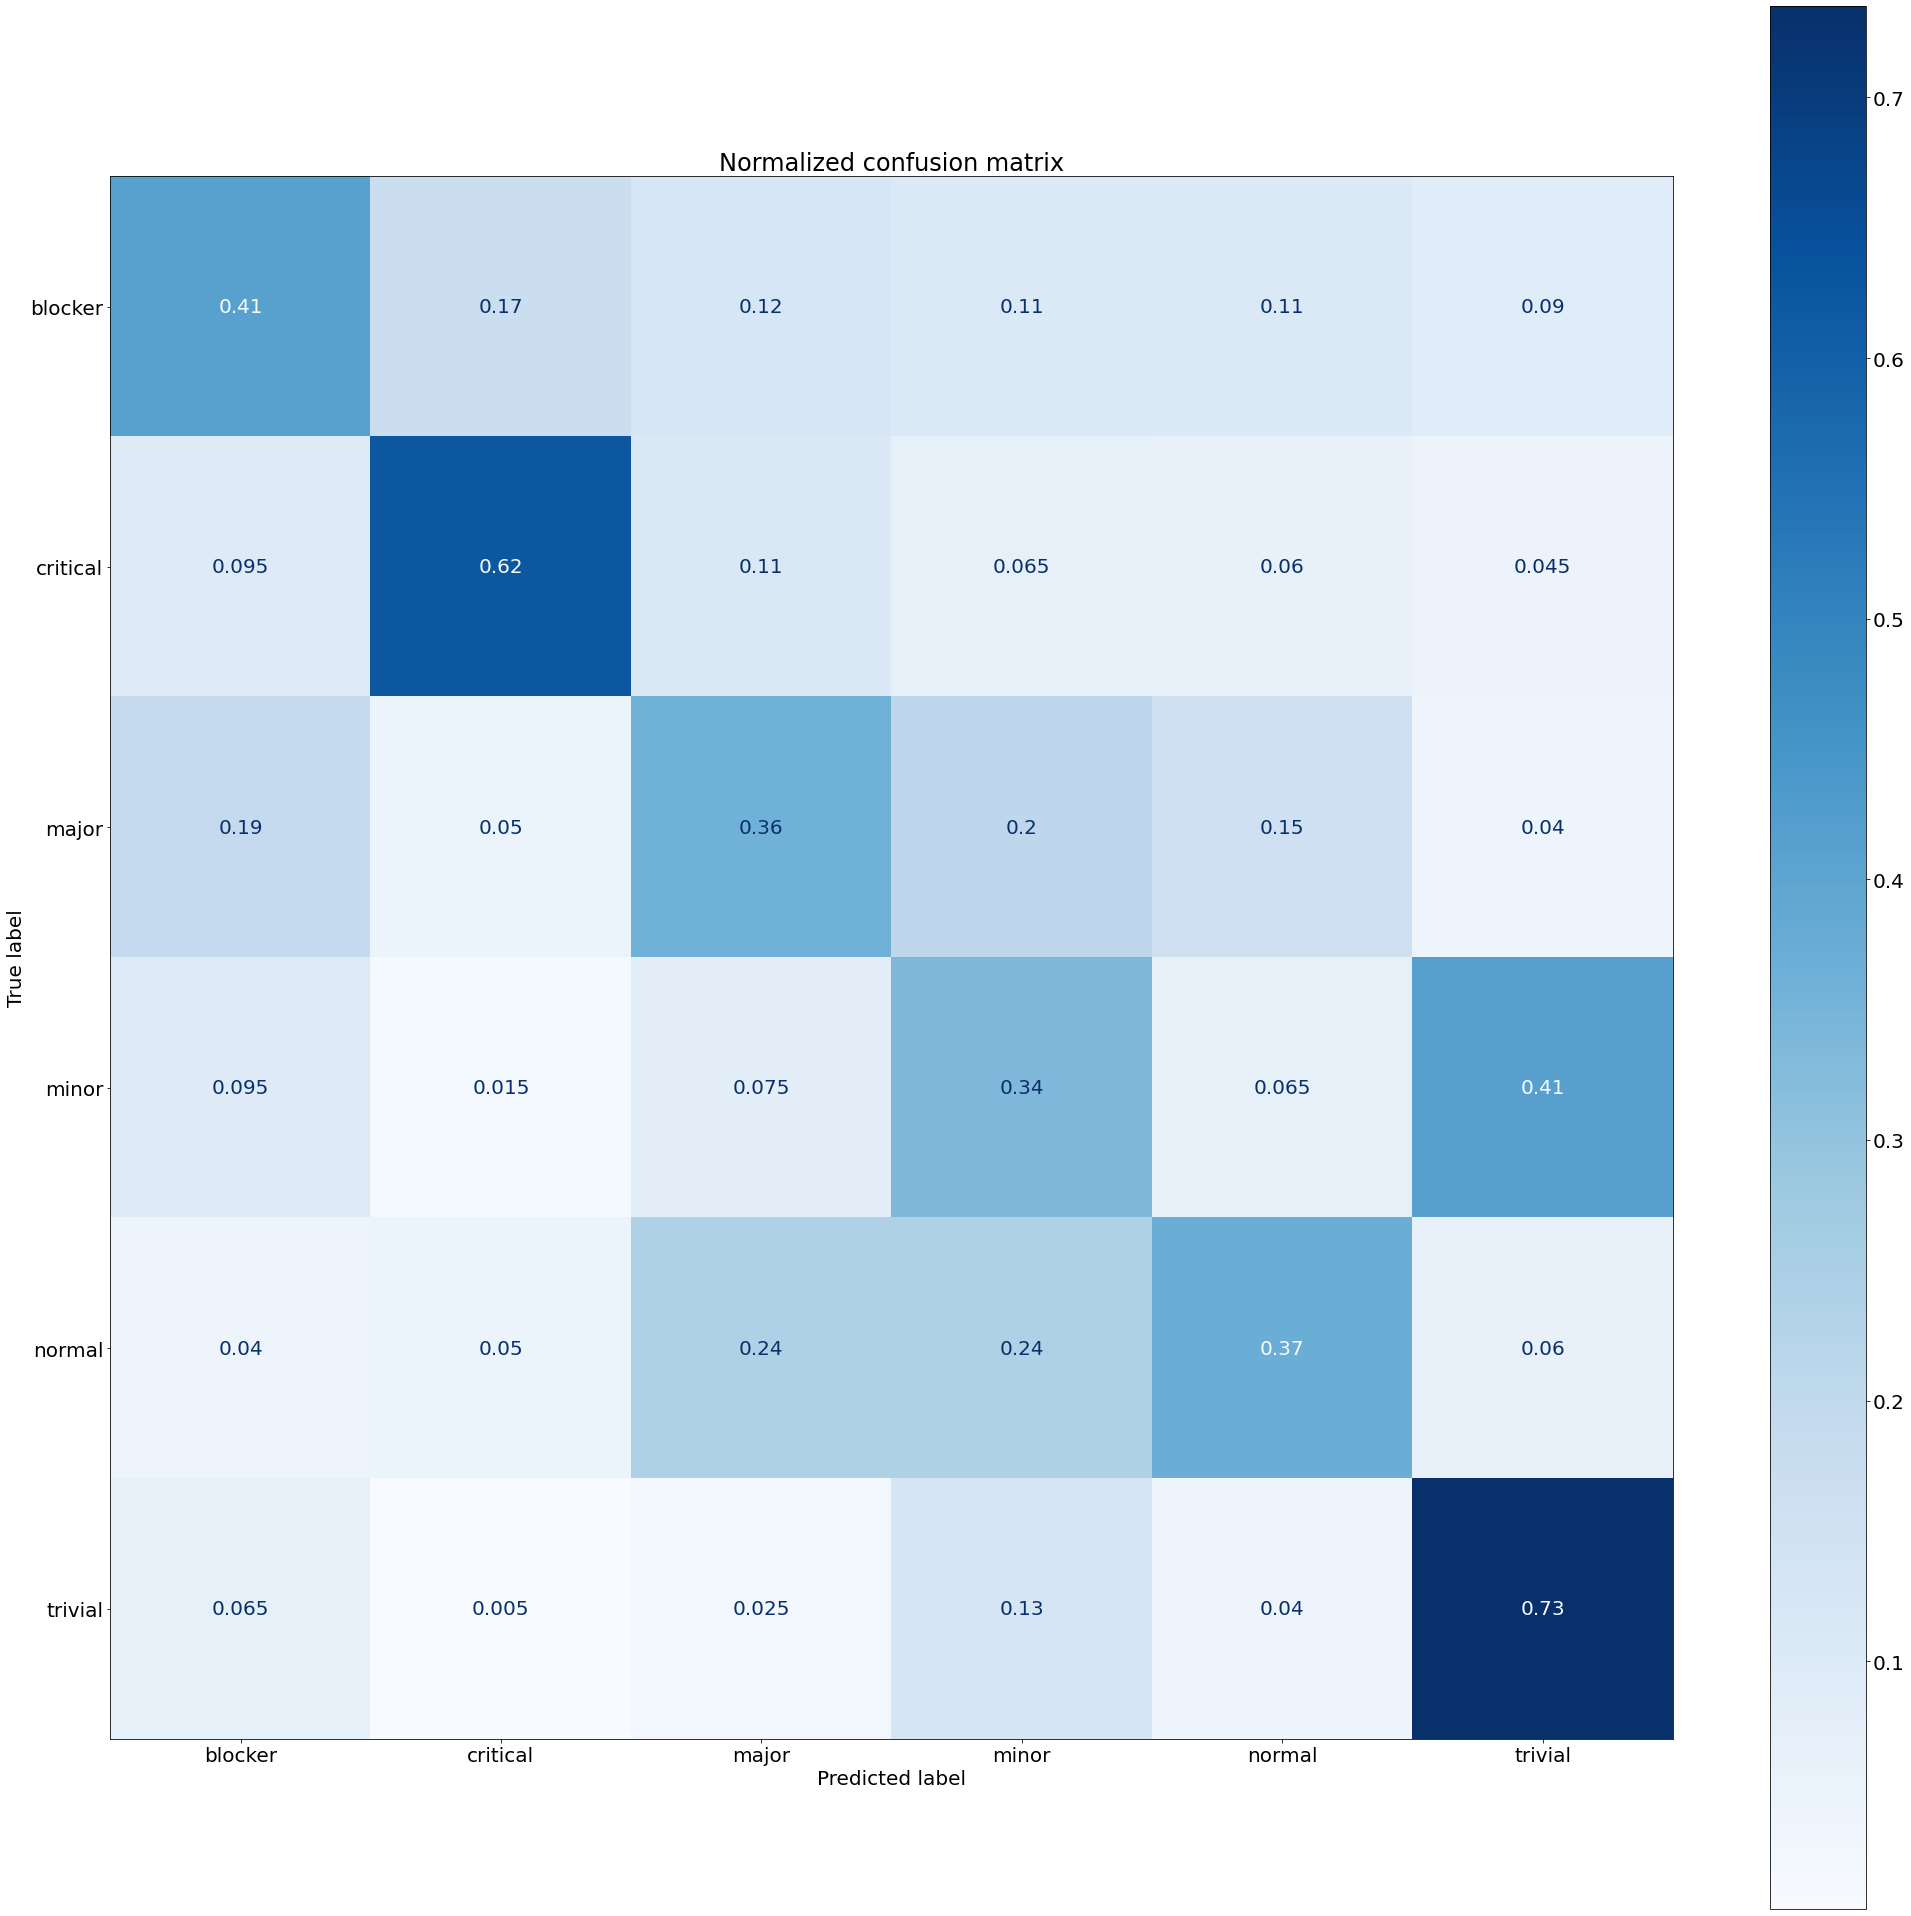

In [37]:
from sklearn.metrics import plot_confusion_matrix
# Plot non-normalized and normalized SGD confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
dis_label = dis_label =['blocker', 'critical', 'major', 'minor', 'normal','trivial']
for title, normalize in titles_options:
    fig, ax = plt.subplots(figsize=(35,35))
    plt.rcParams.update({'font.size': 20})
    disp = plot_confusion_matrix(best_model, x_test, y_test,
                                 display_labels=dis_label,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize,
                                 ax=ax)
    disp.ax_.set_title(title)


 

plt.show()
